## Описание проекта

Задача данного проекта заключается в попытке спрогнозировать температуру на поверхности обнаруженных звёзд при помощи нескольких методов и применении нейросети как инструмента решения задачи.

Для решения задачи будет использованна база данных о 240 звёздах любезно предоставленная обсерваторией «Небо на ладони».

## Загрузка данных

Устанавливаем необходимые библиотеки

In [1]:
# LightGBM
#%pip install lightgbm
# CatBoost
#%pip install catboost
# torch
#%pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

Импортируем библиотеки согласно стандарту PEP-8

In [2]:
# стандартные библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns

# сторонние библиотеки
from itertools import product
import lightgbm as lgb
from math import ceil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# torch
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Загружаем данные

In [3]:
%%time
try:
    df = pd.read_csv('6_class.csv')
except:
    df = pd.read_csv('/datasets/6_class.csv')

CPU times: user 5.17 ms, sys: 325 µs, total: 5.5 ms
Wall time: 158 ms


Ознакомление с данными

In [4]:
def show_i(data):

    '''Выводим на экран следущую информацию:

    - размер таблицы
    - основную информацию
    - первые 5 строк таблицы
    - суммарная статистика по числовым параметрам
    - суммарная статистика по нечисловым параметрам'''

    display(data.shape)
    display(data.info())
    display(data.head())
    display(data.describe())
    display(data.describe(include=['O']))

In [5]:
show_i(df)

(240, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


,Star color
count,240
unique,19
top,Red
freq,112


`Вывод:` после предварительного ознакомления с данными надо отметить что имяются признаки нуждающиеся в удалении 'Unnamed: 0.1' и	'Unnamed: 0' тк не содержат ценной информации, а лишь дублируют индекс таблицы. 

В таблице два категориальных признака - тип и цвет звезды.

Также, стоит упомянуть что выборка крайне небольшая, всего 240 наблюдений что может внести свои коррективы в обучение подели и её предсказательную способность.

## Предобработка и анализ данных

### Предобработка

Проверим пропуски

In [6]:
# пропуски в абсолютных значениях
display(pd.DataFrame(df.isna().mean()*df.shape[0]).astype(int).style.background_gradient('coolwarm'))

,0
Unnamed: 0,0
Temperature (K),0
Luminosity(L/Lo),0
Radius(R/Ro),0
Absolute magnitude(Mv),0
Star type,0
Star color,0


`Вывод:` пропусков нет

#### Проверим категорияльные значения

In [7]:
# уникальные значения цвета звёзд

print('Количество уникальных цветов звёзд: ', len(df['Star color'].value_counts()))
df['Star color'].value_counts()

Количество уникальных цветов звёзд:  19


Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
white                   3
Blue white              3
yellowish               2
Whitish                 2
Orange                  2
Blue-White              1
Blue white              1
White-Yellow            1
Pale yellow orange      1
Orange-Red              1
Blue                    1
Yellowish               1
Name: Star color, dtype: int64

`Вывод:` наблюдаются схожие по смыслу категории которые следует объединить

In [8]:
# уникальные значения типов звёзд

print('Кол-во типов звёзд: ', len(df['Star type'].value_counts()))
df['Star type'].value_counts()

Кол-во типов звёзд:  6


0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

`Вывод:` отметим, что типы звёзд распределены равномерно, по 40 звёзд каждого типа

Переименовываем неявные дубликаты

In [9]:
df['Star color'] = df['Star color'].replace({r'(\b)Blue-white(\b)':r'\1Blue White\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Blue white(\b)':r'\1Blue White\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Blue-White(\b)':r'\1Blue White\2'}, regex=True)
df['Star color'] = df['Star color'].str.replace('Blue ','Blue')

df['Star color'] = df['Star color'].replace({r'(\b)yellow-white(\b)':r'\1Yellow White\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Yellowish White(\b)':r'\1Yellow White\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)White-Yellow(\b)':r'\1Yellow White\2'}, regex=True)

df['Star color'] = df['Star color'].replace({r'(\b)white(\b)':r'\1White\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Whitish(\b)':r'\1White\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)White-Yellow(\b)':r'\1White\2'}, regex=True)

df['Star color'] = df['Star color'].replace({r'(\b)yellowish(\b)':r'\1Yellow\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Pale yellow orange(\b)':r'\1Yellow\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Yellowish(\b)':r'\1Yellow\2'}, regex=True)
df['Star color'] = df['Star color'].replace({r'(\b)Orange-Red(\b)':r'\1Orange Red\2'}, regex=True)

print('Количество уникальных цветов звёзд: ', len(df['Star color'].value_counts()))
display(df['Star color'].value_counts())

Количество уникальных цветов звёзд:  9


Red             112
Blue             56
BlueWhite        40
White            12
Yellow White     12
Yellow            4
Orange            2
BlueWhite         1
Orange Red        1
Name: Star color, dtype: int64

Остался дубликат с пробелом, переименовываем его в следующем шаге

In [10]:
df['Star color'] = df['Star color'].str.replace('BlueWhite ','Blue White')
df['Star color'] = df['Star color'].str.replace('BlueWhite','Blue White')

print('Количество уникальных цветов звёзд: ', len(df['Star color'].value_counts()))
display(df['Star color'].value_counts())

Количество уникальных цветов звёзд:  8


Red             112
Blue             56
Blue White       41
White            12
Yellow White     12
Yellow            4
Orange            2
Orange Red        1
Name: Star color, dtype: int64

`Вывод:` В итоге из 19 категориальных значений мы пришли к 8-ми цветам звёзд.

Удаляем ненужные колонки которые дублируют значения индекса

In [11]:
#df = df.drop(['Unnamed: 0.1'], axis=1)
df = df.drop(['Unnamed: 0'], axis=1)
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


`Вывод:` в результате предобработки данных были удалены ненужные признаки, данные приведены в более структурированный и информативный вид. Теперь можно приступить к исследовательскому анализу данных.

### ИАД

#### Посмотрим на распределение категориальных данных: тип звезды и цвет звезды

##### Посмотрим на распределение типов звёзд

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

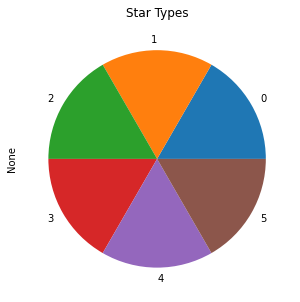

In [12]:
# Выводим общее колво типов звёзд в таблице
display(df['Star type'].value_counts())

# Группируем данные по типу звезды 'Star type'
grouped_df = df.groupby('Star type').size()

# Добавляем название графика
plt.title("Star Types")

# Вывводим сгруппировынные данные в графике
plot = grouped_df.plot.pie(figsize=(5, 5))

`Вывод:` типы звёзд равнораспределены.

##### Посмотрим на распределение цвета звёзд ('Star color')

<AxesSubplot:>

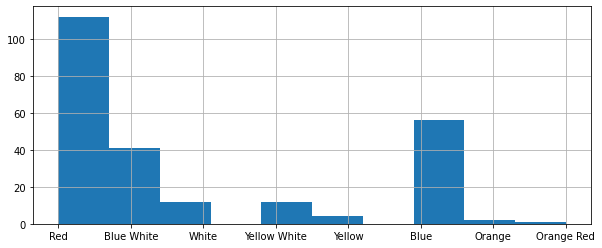

In [13]:
df['Star color'].hist(figsize=(10, 4))

### Меняем 'Star type' из int в object

In [14]:
for i in range(len(df)):
    df.loc[i,'Star type'] = str(df.loc[i,'Star type'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    object 
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


Проверяем результат сметы типа

Переводим признак 'Star type' в категориальные значения

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    object 
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


In [17]:
df = pd.get_dummies(df, drop_first=True)

После кодиовки кодировки

In [18]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue White,Star color_Orange,Star color_Orange Red,Star color_Red,Star color_White,Star color_Yellow,Star color_Yellow White
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,0,0,1,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,0,0,1,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,0,0,1,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,0,0,1,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,0,0,1,0,0,0


После кодирования признаков можно приступить к анализу данных при помощи различных графиков

`Вывод:` мы видим, что почти половина звёзд из выборки красные, со значительным отставанием идут голубые и бело-голубые звёзды. <br>
Со значительным отставанием идут белые и жёлтые звёзды.<br>
Меньше всего оранжевых и оранжко-крассных звёзд.

#### Посмотрим на распределение количественных данных

Создадим функцию чтобы проверить количественные данные на выбросы

In [19]:
def graph(col, min, max):
    df.boxplot(column=col)
    plt.ylim(min, max)
    plt.show()

Проверяем признаки на выбросы

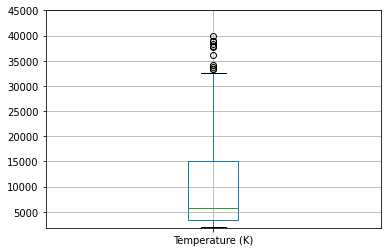

In [20]:
graph('Temperature (K)', 1800, 45000)

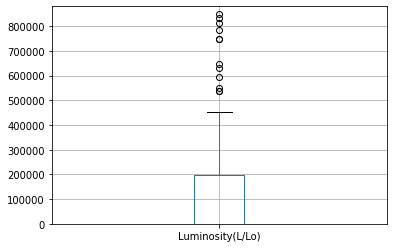

In [21]:
graph('Luminosity(L/Lo)', 0, 880000)

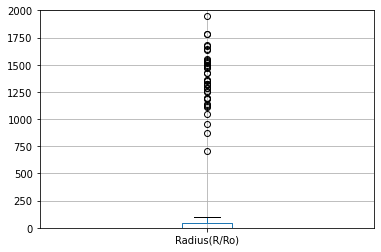

In [22]:
graph('Radius(R/Ro)', 0, 2000)

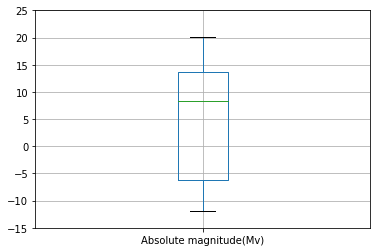

In [23]:
graph('Absolute magnitude(Mv)', -15, 25)

`Вывод:`из графиков выбросов выше следует что наименьшие выбросы наблюдаются у абсолютной магнитуды Mv

Теперь посмотрим на распределение количественных данных на графике для наглядности

Для началы выведем общую гистограмму признаков

<function matplotlib.pyplot.show(close=None, block=None)>

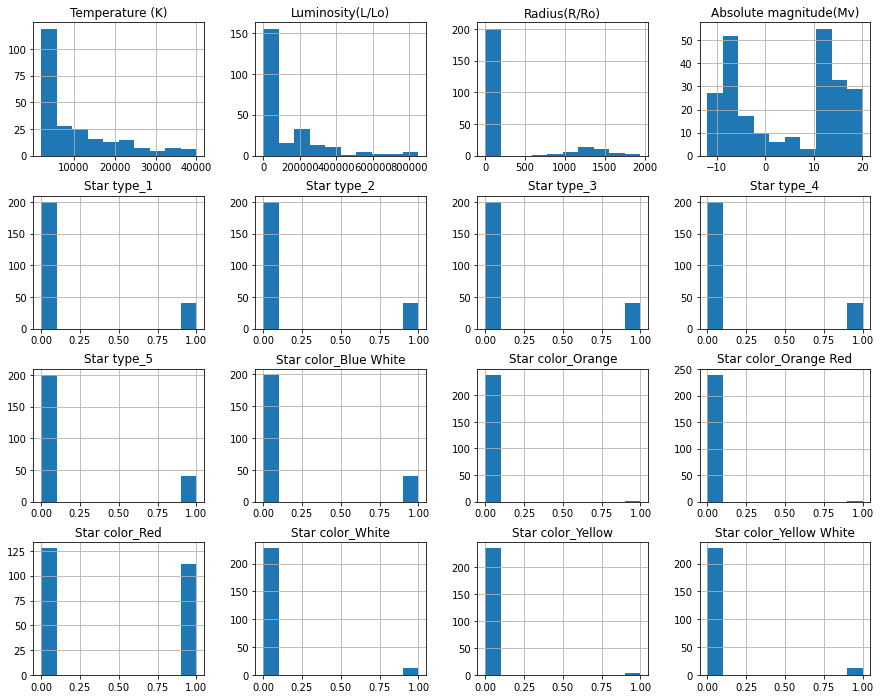

In [24]:
df.hist(figsize=(15, 12))
plt.show

Теперб рассмотрим каждый признак по-отдельноси

Text(0, 0.5, 'Колчество наблюдений')

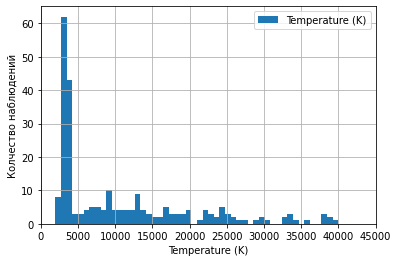

In [25]:
df.plot(y = 'Temperature (K)', kind = 'hist', bins = 50, grid = True)
plt.xlim(0,45000)
plt.xlabel('Temperature (K)')
plt.ylabel('Колчество наблюдений')

Text(0, 0.5, 'Колчество наблюдений')

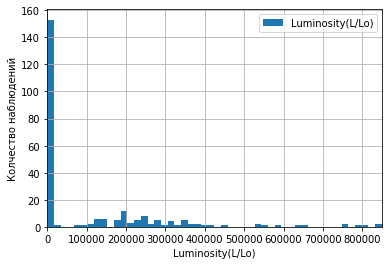

In [26]:
df.plot(y = 'Luminosity(L/Lo)', kind = 'hist', bins = 50, grid = True)
plt.xlim(0,850000)
plt.xlabel('Luminosity(L/Lo)')
plt.ylabel('Колчество наблюдений')

Text(0, 0.5, 'Колчество наблюдений')

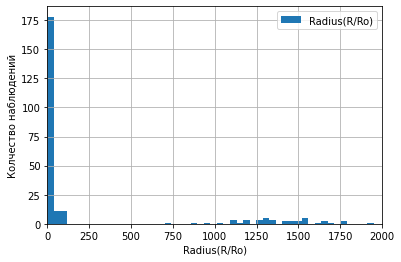

In [27]:
df.plot(y = 'Radius(R/Ro)', kind = 'hist', bins = 50, grid = True)
plt.xlim(0,2000)
plt.xlabel('Radius(R/Ro)')
plt.ylabel('Колчество наблюдений')

Text(0, 0.5, 'Колчество наблюдений')

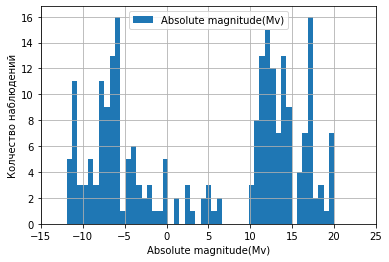

In [28]:
df.plot(y = 'Absolute magnitude(Mv)', kind = 'hist', bins = 50, grid = True)
plt.xlim(-15,25)
plt.xlabel('Absolute magnitude(Mv)')
plt.ylabel('Колчество наблюдений')

`Вывод:`

В итоге получаем обработанный датасет готовый к дальнейшей работе.

In [29]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue White,Star color_Orange,Star color_Orange Red,Star color_Red,Star color_White,Star color_Yellow,Star color_Yellow White
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,0,0,1,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,0,0,1,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,0,0,1,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,0,0,1,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,0,0,1,0,0,0


После того как мы перевели все признаки в числовой вид, можем провести анализ корреляции признаков.

Целевой признак - Температура взезды к Кельвинах `'Temperature (K)'`

<AxesSubplot:>

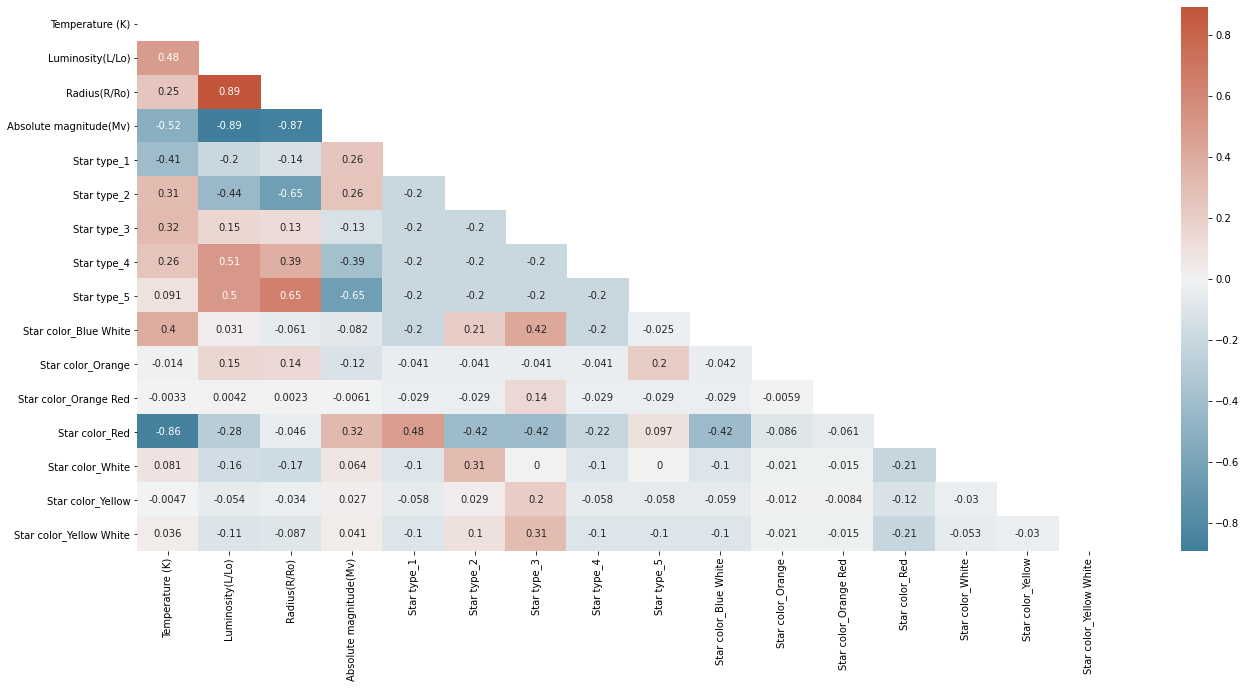

In [30]:
# корреляция между разными значениями
corr = df.corr(method='spearman')

# установка matplotlib plot конфигурации
f, ax = plt.subplots(figsize=(22, 10))

# задаём схему графика
mask = np.triu(np.ones_like(corr, dtype=bool))

# устанавливаем цвет
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# выводим график
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)


`Вывод:` скольно нибудь значимой кореляции с целевым признаком 'Temperature (K)' не прослеживается, за исключением звёзд красного цвета. Это говорит о том, что комбинаторика признаков носит более сложный характер. Простой таблицы корреляций, очевидно, не достаточно для выявления закономерностей которые помогут нам предсказть температуру звезды.<br>
Для предсказиния температуры мы прибегнем к построению нейронной сети.

## Построение базовой нейронной сети

### Подготовка данных к построению модели

Разделим выборки на обучающую и тестовую

In [31]:
X = df.drop('Temperature (K)', axis=1)
y = df['Temperature (K)']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.1, shuffle=True)

Выводим размеры полученных выборок

In [32]:
print('X_train.shape ',X_train.shape)
print('X_test.shape  ',X_test.shape)
print('y_train.shape ',y_train.shape)
print('y_test.shape  ',y_test.shape)

X_train.shape  (216, 15)
X_test.shape   (24, 15)
y_train.shape  (216,)
y_test.shape   (24,)


In [33]:
X

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_Blue White,Star color_Orange,Star color_Orange Red,Star color_Red,Star color_White,Star color_Yellow,Star color_Yellow White
0,0.002400,0.1700,16.12,0,0,0,0,0,0,0,0,1,0,0,0
1,0.000500,0.1542,16.60,0,0,0,0,0,0,0,0,1,0,0,0
2,0.000300,0.1020,18.70,0,0,0,0,0,0,0,0,1,0,0,0
3,0.000200,0.1600,16.65,0,0,0,0,0,0,0,0,1,0,0,0
4,0.000138,0.1030,20.06,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,374830.000000,1356.0000,-9.93,0,0,0,0,1,0,0,0,0,0,0,0
236,834042.000000,1194.0000,-10.63,0,0,0,0,1,0,0,0,0,0,0,0
237,537493.000000,1423.0000,-10.73,0,0,0,0,1,0,0,0,0,1,0,0
238,404940.000000,1112.0000,-11.23,0,0,0,0,1,0,0,0,0,1,0,0


Проведём масштабирование количественных данных нецелевых (X_train, X_test) выборок

In [34]:
pd.options.mode.chained_assignment = None
numeric = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# масштабирование
scaler = StandardScaler()
scaler.fit(X_train[numeric])




X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

Трансформируем в массив torch

In [35]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

### Построение базовой модели

Гиперпараметры

In [36]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

Обучаем базовую модель

In [37]:

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)  # входной слой
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)  # скрытый слой
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)  # выходной слой
        #self.act3 = nn.Identity()  # активация nn.Identity для регрессии 
        self.act3 = nn.ReLU() 

        # инициализация весов используя однородную инициализацию Kaiming
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        return x


In [61]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

In [62]:
num_epochs = 500 # кол-во эпох обучения сети
optimizer = torch.optim.Adam(net.parameters(), lr=0.3) 
loss = nn.MSELoss()

for epoch in range(num_epochs):
    optimizer.zero_grad() # обнуление градиента
    preds = net.forward(X_train) # прямое распространение на обучающих данных
    loss_value = loss(preds.flatten(), y_train.flatten()) # вычисление значения функции потерь
    loss_value.backward() # вычисление градиентов
    optimizer.step()
    
    if epoch % 10 == 0: # вычислим метрики качества каждую десятую эпоху
        net.eval() # переводим модель в режим предсказания
        test_preds = net(X_test)
        mse_value = loss(test_preds.flatten(), y_test.flatten())
        rmse_value = torch.sqrt(mse_value)
        print("RMSE:", rmse_value.item(), "Эпоха:", epoch)

RMSE: 17630.578125 Эпоха: 0
RMSE: 11358.95703125 Эпоха: 10
RMSE: 8251.365234375 Эпоха: 20
RMSE: 5861.14892578125 Эпоха: 30
RMSE: 4575.220703125 Эпоха: 40
RMSE: 4529.3056640625 Эпоха: 50
RMSE: 4937.35400390625 Эпоха: 60
RMSE: 4891.83154296875 Эпоха: 70
RMSE: 4812.900390625 Эпоха: 80
RMSE: 4749.021484375 Эпоха: 90
RMSE: 4969.06201171875 Эпоха: 100
RMSE: 4887.95458984375 Эпоха: 110
RMSE: 4936.53173828125 Эпоха: 120
RMSE: 4951.3125 Эпоха: 130
RMSE: 4951.9306640625 Эпоха: 140
RMSE: 4855.1904296875 Эпоха: 150
RMSE: 4988.6201171875 Эпоха: 160
RMSE: 4518.38330078125 Эпоха: 170
RMSE: 4916.0390625 Эпоха: 180
RMSE: 4598.84423828125 Эпоха: 190
RMSE: 5273.46826171875 Эпоха: 200
RMSE: 4632.59228515625 Эпоха: 210
RMSE: 4767.16796875 Эпоха: 220
RMSE: 5595.921875 Эпоха: 230
RMSE: 5124.09765625 Эпоха: 240
RMSE: 4735.14111328125 Эпоха: 250
RMSE: 4879.076171875 Эпоха: 260
RMSE: 4590.6728515625 Эпоха: 270
RMSE: 4571.173828125 Эпоха: 280
RMSE: 4922.71337890625 Эпоха: 290
RMSE: 4701.966796875 Эпоха: 300
RMSE

In [40]:
final_preds_base_mod = net.forward(X_test)

Строим график прогнозов - "Факт-прогноз"

In [41]:
def graph2(target, preds, width = 0.4): 
    y1 = target 
    y2 = preds 
    x = np.arange(len(y1)) 
    fig,ax = plt.subplots() 
    rects1 = ax.bar(x , y1, width, label = 'Факт', color = '#AED9E4') 
    rects2 = ax.bar(x, y2, width/3, label = 'Прогноз', color = '#E9B940') 
    ax.set_title('Факт - Прогноз') 
    ax.set_xticks(x) 
    ax.set_xlabel('Номер') 
    ax.set_ylabel('Температура') 
    fig.set_figwidth(20) 
    fig.set_figheight(10) 
    ax.legend()

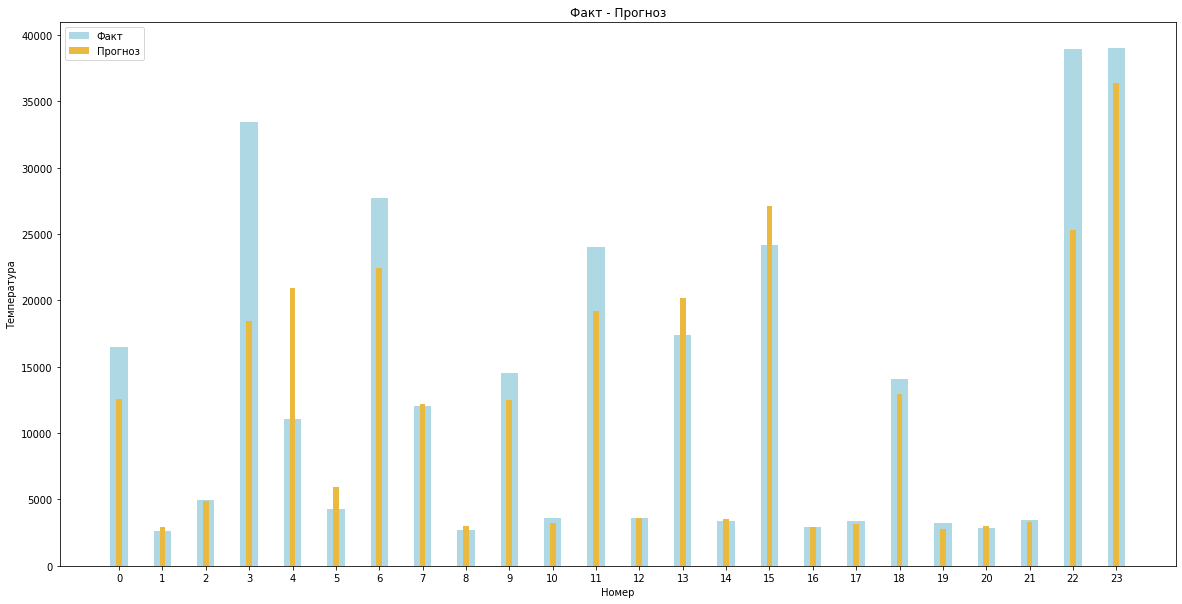

In [42]:
target = y_test
target = target.numpy()
target = pd.Series(target)

preds = final_preds_base_mod.detach().numpy()

preds =  pd.Series([x[0] for x in preds])

# Вызов функции для построения графика
graph2(target, preds)
plt.show()

`Вывод:` RMSE=3567 целевой показатель RMSE <4500 достигнут. Посмотрим, можем ли мы улучшить модель для достижения более низкого RMSE <br>

Модель хорошо предсказывает малые и значения, но не очень хорошо - средние и большие. 

## Улучшение нейронной сети

Улучшение 1 - изменим кол-во батчей batch=6

In [63]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.act1 = nn.ReLU() 
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU() 
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) #инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act1(x) 
 
        x = self.fc2(x) 
        x = self.act2(x) 
 
        x = self.fc3(x) 
        x = self.act3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=0.3)


batch_size = 6
num_epochs = 500
num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
        optimizer.zero_grad()  
        batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча    
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]  
        preds = net.forward(X_batch).flatten()          
        loss_value = loss(preds, y_batch)
        loss_value.backward()          
        optimizer.step() 
       
    if epoch % 20 == 0:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE = torch.sqrt(loss(test_preds.flatten(),y_test.flatten()))
        print(RMSE) 
        
        
        
full_predictions = net.forward(X_test)

tensor(9895.5732, grad_fn=<SqrtBackward0>)
tensor(5674.7144, grad_fn=<SqrtBackward0>)
tensor(5362.9487, grad_fn=<SqrtBackward0>)
tensor(5078.3999, grad_fn=<SqrtBackward0>)
tensor(4906.3218, grad_fn=<SqrtBackward0>)
tensor(6204.9536, grad_fn=<SqrtBackward0>)
tensor(5122.7397, grad_fn=<SqrtBackward0>)
tensor(4312.6113, grad_fn=<SqrtBackward0>)
tensor(4899.7959, grad_fn=<SqrtBackward0>)
tensor(4652.6865, grad_fn=<SqrtBackward0>)
tensor(6371.9336, grad_fn=<SqrtBackward0>)
tensor(4627.9868, grad_fn=<SqrtBackward0>)
tensor(5142.0381, grad_fn=<SqrtBackward0>)
tensor(5397.8550, grad_fn=<SqrtBackward0>)
tensor(5626.9995, grad_fn=<SqrtBackward0>)
tensor(5491.1680, grad_fn=<SqrtBackward0>)
tensor(6748.2681, grad_fn=<SqrtBackward0>)
tensor(5623.5532, grad_fn=<SqrtBackward0>)
tensor(5884.5908, grad_fn=<SqrtBackward0>)
tensor(5775.2056, grad_fn=<SqrtBackward0>)
tensor(5015.7554, grad_fn=<SqrtBackward0>)
tensor(5700.1338, grad_fn=<SqrtBackward0>)
tensor(5546.7520, grad_fn=<SqrtBackward0>)
tensor(4473

Строим график

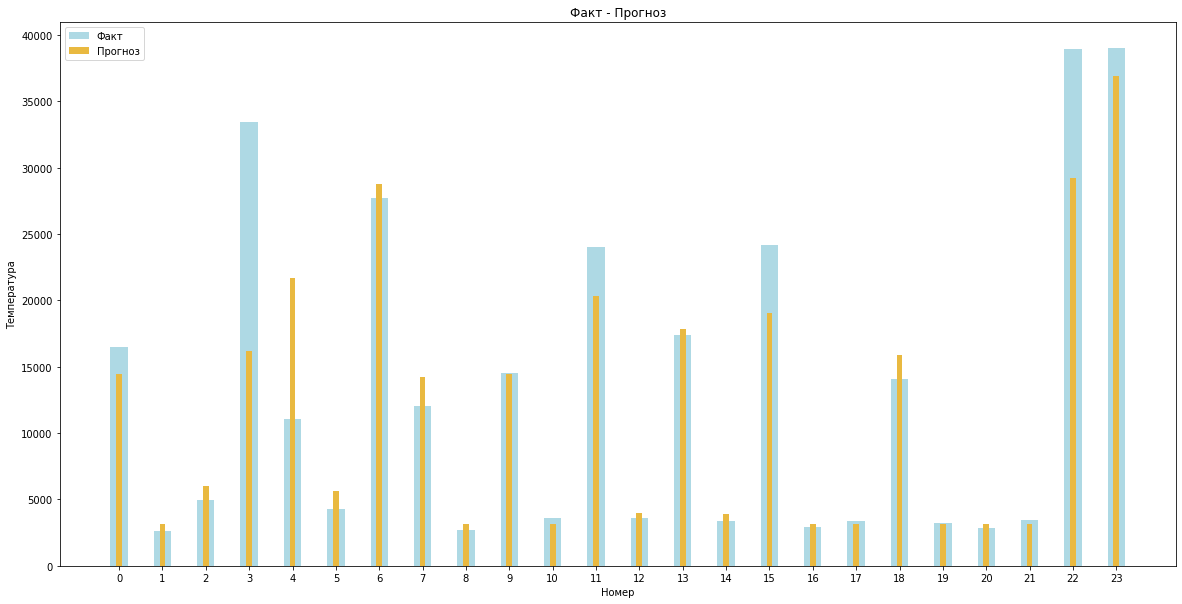

In [64]:
target = y_test
target = target.numpy()
target = pd.Series(target)


full_predictions = full_predictions.detach().numpy()

preds =  pd.Series([x[0] for x in full_predictions])

# Вызов функции для построения графика
graph2(target, preds)
plt.show()

Batch size = 50

In [45]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.act1 = nn.ReLU() 
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU() 
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) #инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act1(x) 
 
        x = self.fc2(x) 
        x = self.act2(x) 
 
        x = self.fc3(x) 
        x = self.act3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=0.3)


batch_size = 50
num_epochs = 500
num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
        optimizer.zero_grad()  
        batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча    
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]  
        preds = net.forward(X_batch).flatten()          
        loss_value = loss(preds, y_batch)
        loss_value.backward()          
        optimizer.step() 
       
    if epoch % 20 == 0:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE = torch.sqrt(loss(test_preds.flatten(),y_test.flatten()))
        print(RMSE) 
        
        
        
full_predictions = net.forward(X_test)

tensor(16431.5195, grad_fn=<SqrtBackward0>)
tensor(4324.6143, grad_fn=<SqrtBackward0>)
tensor(5104.2480, grad_fn=<SqrtBackward0>)
tensor(4631.0337, grad_fn=<SqrtBackward0>)
tensor(4345.7539, grad_fn=<SqrtBackward0>)
tensor(6141.4341, grad_fn=<SqrtBackward0>)
tensor(4773.6167, grad_fn=<SqrtBackward0>)
tensor(5287.1157, grad_fn=<SqrtBackward0>)
tensor(5188.7153, grad_fn=<SqrtBackward0>)
tensor(4652.3130, grad_fn=<SqrtBackward0>)
tensor(5104.0527, grad_fn=<SqrtBackward0>)
tensor(4309.3633, grad_fn=<SqrtBackward0>)
tensor(4892.7637, grad_fn=<SqrtBackward0>)
tensor(5293.2261, grad_fn=<SqrtBackward0>)
tensor(5467.6997, grad_fn=<SqrtBackward0>)
tensor(4340.7378, grad_fn=<SqrtBackward0>)
tensor(4818.9146, grad_fn=<SqrtBackward0>)
tensor(4934.4546, grad_fn=<SqrtBackward0>)
tensor(5044.7666, grad_fn=<SqrtBackward0>)
tensor(4807.1855, grad_fn=<SqrtBackward0>)
tensor(5021.0957, grad_fn=<SqrtBackward0>)
tensor(4787.9834, grad_fn=<SqrtBackward0>)
tensor(5107.9805, grad_fn=<SqrtBackward0>)
tensor(482

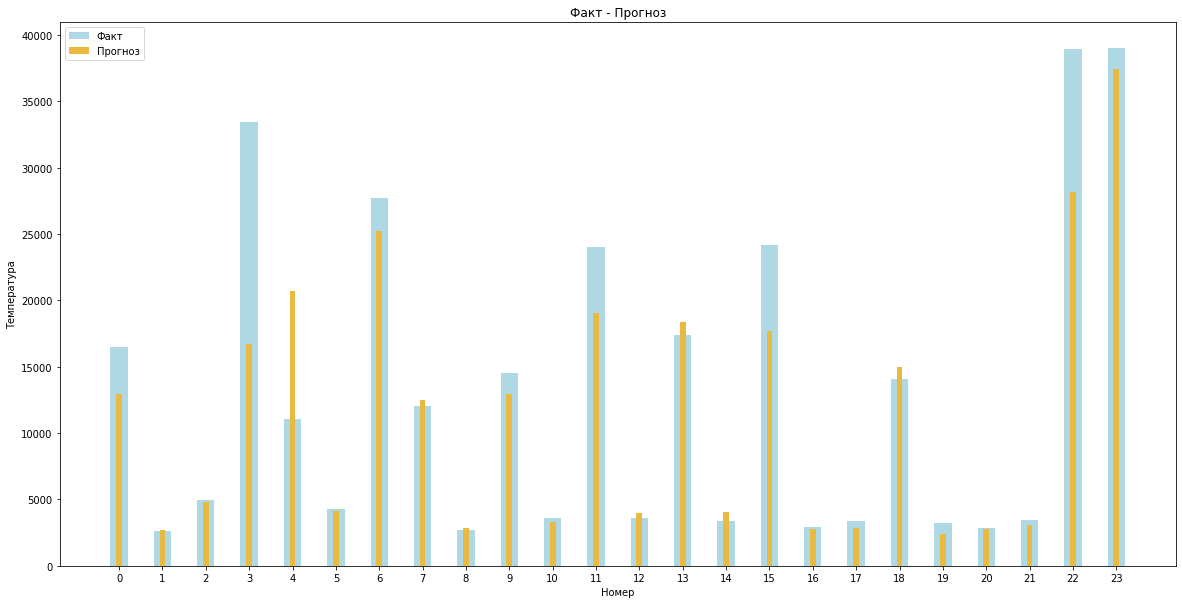

In [46]:
target = y_test
target = target.numpy()
target = pd.Series(target)

#full_predictions = final_preds_base.detach().numpy()
full_predictions = full_predictions.detach().numpy()

preds =  pd.Series([x[0] for x in full_predictions])

# Вызов функции для построения графика
graph2(target, preds)
plt.show()

Batch size = 70

In [47]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.act1 = nn.ReLU() 
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU() 
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) #инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act1(x) 
 
        x = self.fc2(x) 
        x = self.act2(x) 
 
        x = self.fc3(x) 
        x = self.act3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=0.3)


batch_size = 70
num_epochs = 500
num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
        optimizer.zero_grad()  
        batch_indexes = order[start_index:start_index+batch_size] # извлеките индексы объектов текущего обатча    
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]  
        preds = net.forward(X_batch).flatten()          
        loss_value = loss(preds, y_batch)
        loss_value.backward()          
        optimizer.step() 
       
    if epoch % 20 == 0:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE = torch.sqrt(loss(test_preds.flatten(),y_test.flatten()))
        print(RMSE) 
        
        
        
full_predictions = net.forward(X_test)

tensor(17345.3105, grad_fn=<SqrtBackward0>)
tensor(5840.3955, grad_fn=<SqrtBackward0>)
tensor(4386.3018, grad_fn=<SqrtBackward0>)
tensor(4357.9585, grad_fn=<SqrtBackward0>)
tensor(5152.9019, grad_fn=<SqrtBackward0>)
tensor(5172.1284, grad_fn=<SqrtBackward0>)
tensor(5145.9067, grad_fn=<SqrtBackward0>)
tensor(4468.1050, grad_fn=<SqrtBackward0>)
tensor(4428.1382, grad_fn=<SqrtBackward0>)
tensor(5358.3481, grad_fn=<SqrtBackward0>)
tensor(3821.6653, grad_fn=<SqrtBackward0>)
tensor(5939.5459, grad_fn=<SqrtBackward0>)
tensor(5273.6309, grad_fn=<SqrtBackward0>)
tensor(5096.2510, grad_fn=<SqrtBackward0>)
tensor(5692.8550, grad_fn=<SqrtBackward0>)
tensor(4866.0635, grad_fn=<SqrtBackward0>)
tensor(5839.9854, grad_fn=<SqrtBackward0>)
tensor(4408.0356, grad_fn=<SqrtBackward0>)
tensor(4734.3853, grad_fn=<SqrtBackward0>)
tensor(4576.3457, grad_fn=<SqrtBackward0>)
tensor(4921.8682, grad_fn=<SqrtBackward0>)
tensor(4900.6904, grad_fn=<SqrtBackward0>)
tensor(4429.8071, grad_fn=<SqrtBackward0>)
tensor(594

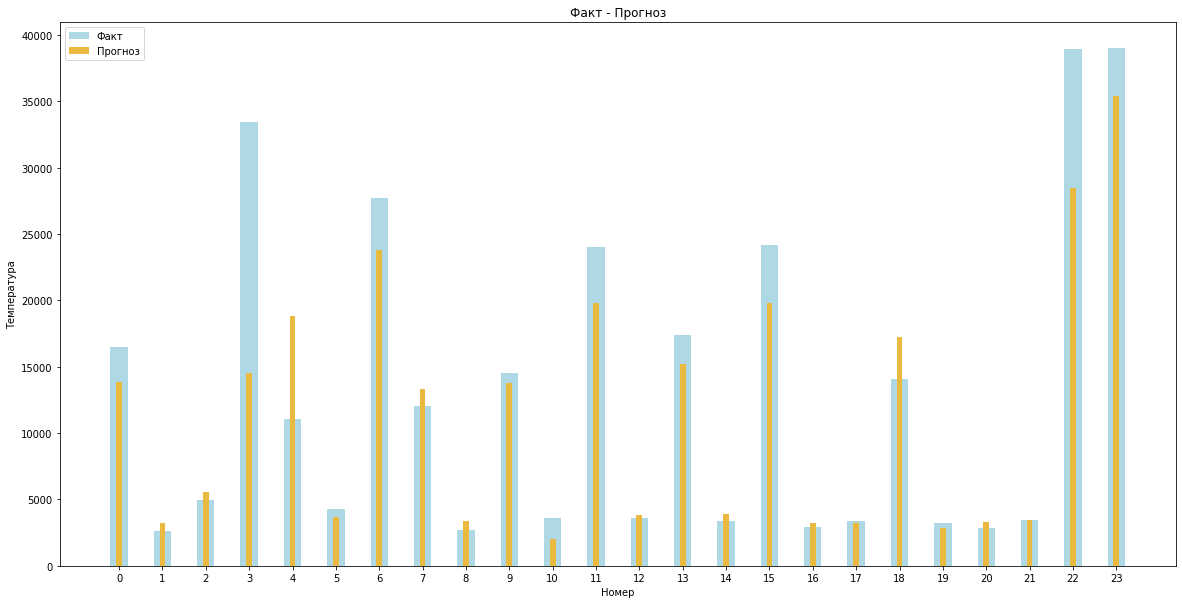

In [48]:
target = y_test
target = target.numpy()
target = pd.Series(target)

full_predictions = full_predictions.detach().numpy()

preds =  pd.Series([x[0] for x in full_predictions])

# Вызов функции для построения графика
graph2(target, preds)
plt.show()

Улучшение 2 - применяем Dropout (p=0.2)

In [49]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.act1 = nn.ReLU() 
        self.dp1 = nn.Dropout(p=0.2)
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.2)
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
        self.dp3 = nn.Dropout(p=0.2)
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) #инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act1(x) 
        x = self.dp1(x)
        x = self.fc2(x) 
        x = self.act2(x)
        x = self.dp2(x) 
        x = self.fc3(x) 
        x = self.act3(x)
        x = self.dp3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)




num_epochs = 500 # кол-во эпох обучения сети
optimizer = torch.optim.Adam(net.parameters(), lr=0.3) 
loss = nn.MSELoss()

for epoch in range(num_epochs):
    optimizer.zero_grad()#обнуляем накопленный градиент
    preds_d = net.forward(X_train) # прямое распространение на обучающих данных
    loss_value = loss(preds_d.flatten(), y_train.flatten()) # вычисление значения функции потерь
    loss_value.backward()# вычисление градиентов
    optimizer.step()
    
    if epoch % 10 == 0: #вычислим метрики качества каждую десятую эпоху
        net.eval() #переводим модель в режим предсказания
        test_preds = net(X_test)
        mse_value = loss(test_preds.flatten(), y_test.flatten())
        rmse_value = torch.sqrt(mse_value)
        print("RMSE:", rmse_value.item(), "Эпоха:", epoch)

RMSE: 17642.740234375 Эпоха: 0
RMSE: 11242.1005859375 Эпоха: 10
RMSE: 10835.662109375 Эпоха: 20
RMSE: 8701.8671875 Эпоха: 30
RMSE: 7887.41943359375 Эпоха: 40
RMSE: 7002.720703125 Эпоха: 50
RMSE: 6011.3896484375 Эпоха: 60
RMSE: 5094.60595703125 Эпоха: 70
RMSE: 4777.46142578125 Эпоха: 80
RMSE: 4657.89208984375 Эпоха: 90
RMSE: 4618.890625 Эпоха: 100
RMSE: 4636.9755859375 Эпоха: 110
RMSE: 4648.64599609375 Эпоха: 120
RMSE: 4646.91162109375 Эпоха: 130
RMSE: 4636.22705078125 Эпоха: 140
RMSE: 4643.80126953125 Эпоха: 150
RMSE: 4639.51806640625 Эпоха: 160
RMSE: 4659.80322265625 Эпоха: 170
RMSE: 4644.58837890625 Эпоха: 180
RMSE: 4651.74609375 Эпоха: 190
RMSE: 4649.3740234375 Эпоха: 200
RMSE: 4666.2373046875 Эпоха: 210
RMSE: 4662.7177734375 Эпоха: 220
RMSE: 4675.1220703125 Эпоха: 230
RMSE: 4686.16357421875 Эпоха: 240
RMSE: 4694.9306640625 Эпоха: 250
RMSE: 4685.6279296875 Эпоха: 260
RMSE: 4704.53857421875 Эпоха: 270
RMSE: 4716.5078125 Эпоха: 280
RMSE: 4718.73583984375 Эпоха: 290
RMSE: 4719.41943359

Применяем Dropout (p=0.3)

In [50]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.act1 = nn.ReLU() 
        self.dp1 = nn.Dropout(p=0.3)
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.3)
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
        self.dp3 = nn.Dropout(p=0.3)
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) # инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act1(x) 
        x = self.dp1(x)
        x = self.fc2(x) 
        x = self.act2(x)
        x = self.dp2(x) 
        x = self.fc3(x) 
        x = self.act3(x)
        x = self.dp3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)


num_epochs = 500 # кол-во эпох обучения сети
optimizer = torch.optim.Adam(net.parameters(), lr=0.3) 
loss = nn.MSELoss()

for epoch in range(num_epochs):
    optimizer.zero_grad() # обнуляем накопленный градиент
    preds_d = net.forward(X_train) # прямое распространение на обучающих данных
    loss_value = loss(preds_d.flatten(), y_train.flatten()) # вычисление значения функции потерь
    loss_value.backward() # вычисление градиентов
    optimizer.step()
    
    if epoch % 10 == 0: # вычислим метрики качества каждую десятую эпоху
        net.eval() # переводим модель в режим предсказания
        test_preds = net(X_test)
        mse_value = loss(test_preds.flatten(), y_test.flatten())
        rmse_value = torch.sqrt(mse_value)
        print("RMSE:", rmse_value.item(), "Эпоха:", epoch)

RMSE: 17611.71875 Эпоха: 0
RMSE: 10564.009765625 Эпоха: 10
RMSE: 9552.0869140625 Эпоха: 20
RMSE: 8580.9970703125 Эпоха: 30
RMSE: 7106.85302734375 Эпоха: 40
RMSE: 5662.291015625 Эпоха: 50
RMSE: 4751.70458984375 Эпоха: 60
RMSE: 4738.5185546875 Эпоха: 70
RMSE: 4634.04248046875 Эпоха: 80
RMSE: 4539.50390625 Эпоха: 90
RMSE: 4522.2998046875 Эпоха: 100
RMSE: 4516.859375 Эпоха: 110
RMSE: 4541.99658203125 Эпоха: 120
RMSE: 4545.18994140625 Эпоха: 130
RMSE: 4549.81884765625 Эпоха: 140
RMSE: 4563.30712890625 Эпоха: 150
RMSE: 4576.705078125 Эпоха: 160
RMSE: 4566.3037109375 Эпоха: 170
RMSE: 4634.24853515625 Эпоха: 180
RMSE: 4643.17578125 Эпоха: 190
RMSE: 4665.14208984375 Эпоха: 200
RMSE: 4682.21826171875 Эпоха: 210
RMSE: 4737.19091796875 Эпоха: 220
RMSE: 4738.91455078125 Эпоха: 230
RMSE: 4765.80810546875 Эпоха: 240
RMSE: 4760.51318359375 Эпоха: 250
RMSE: 4769.2421875 Эпоха: 260
RMSE: 4797.76611328125 Эпоха: 270
RMSE: 4832.19091796875 Эпоха: 280
RMSE: 4835.66162109375 Эпоха: 290
RMSE: 4850.3540039062

Применяем Dropout (p=0.5)

In [51]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.act1 = nn.ReLU() 
        self.dp1 = nn.Dropout(p=0.5)
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.5)
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
        self.dp3 = nn.Dropout(p=0.5)
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) # инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act1(x) 
        x = self.dp1(x)
        x = self.fc2(x) 
        x = self.act2(x)
        x = self.dp2(x) 
        x = self.fc3(x) 
        x = self.act3(x)
        x = self.dp3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)




num_epochs = 500 # кол-во эпох обучения сети
optimizer = torch.optim.Adam(net.parameters(), lr=0.3) 
loss = nn.MSELoss()

for epoch in range(num_epochs):
    optimizer.zero_grad() # обнуляем накопленный градиент
    preds_d = net.forward(X_train) # прямое распространение на обучающих данных
    loss_value = loss(preds_d.flatten(), y_train.flatten()) # вычисление значения функции потерь
    loss_value.backward() # вычисление градиентов
    optimizer.step()
    
    if epoch % 10 == 0: # вычислим метрики качества каждую десятую эпоху
        net.eval() # переводим модель в режим предсказания
        test_preds = net(X_test)
        mse_value = loss(test_preds.flatten(), y_test.flatten())
        rmse_value = torch.sqrt(mse_value)
        print("RMSE:", rmse_value.item(), "Эпоха:", epoch)

RMSE: 17631.822265625 Эпоха: 0
RMSE: 10528.2509765625 Эпоха: 10
RMSE: 10763.3203125 Эпоха: 20
RMSE: 8597.138671875 Эпоха: 30
RMSE: 7782.296875 Эпоха: 40
RMSE: 7055.20166015625 Эпоха: 50
RMSE: 5911.220703125 Эпоха: 60
RMSE: 5183.9580078125 Эпоха: 70
RMSE: 4728.28173828125 Эпоха: 80
RMSE: 4651.48876953125 Эпоха: 90
RMSE: 4610.7041015625 Эпоха: 100
RMSE: 4627.19873046875 Эпоха: 110
RMSE: 4657.0439453125 Эпоха: 120
RMSE: 4662.5654296875 Эпоха: 130
RMSE: 4645.8759765625 Эпоха: 140
RMSE: 4626.13818359375 Эпоха: 150
RMSE: 4637.69921875 Эпоха: 160
RMSE: 4652.02490234375 Эпоха: 170
RMSE: 4630.10498046875 Эпоха: 180
RMSE: 4665.5419921875 Эпоха: 190
RMSE: 4689.22705078125 Эпоха: 200
RMSE: 4724.3662109375 Эпоха: 210
RMSE: 4759.85986328125 Эпоха: 220
RMSE: 4734.4921875 Эпоха: 230
RMSE: 4758.9111328125 Эпоха: 240
RMSE: 4781.8984375 Эпоха: 250
RMSE: 4780.35791015625 Эпоха: 260
RMSE: 4776.04443359375 Эпоха: 270
RMSE: 4791.201171875 Эпоха: 280
RMSE: 4802.0771484375 Эпоха: 290
RMSE: 4797.39013671875 Эпо

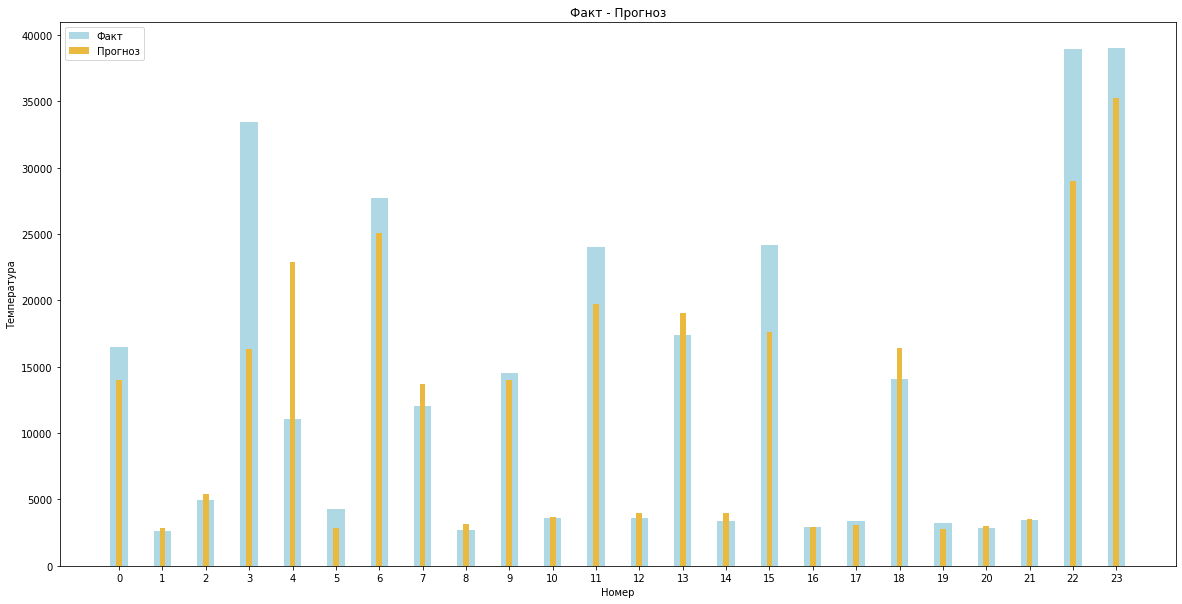

In [52]:
target = y_test
target = target.numpy()
target = pd.Series(target)

test_preds = test_preds.detach().numpy()

preds =  pd.Series([x[0] for x in test_preds])

# Вызов функции для построения графика
graph2(target, preds)
plt.show()

Улучшение 3 - с помощью nn.BatchNorm1d

In [53]:
n_in_neurons = 15 # количество входных нейронов соответствующее количеству принаков
n_hidden_neurons_1 = 25 # первый скрытый слой
n_hidden_neurons_2 = 25 # второй скрытый слой
n_out_neurons = 1 # один нейрон на выходе тк решвается задаче регрессии

class Net(nn.Module): 
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons): 
        super(Net, self).__init__() 
 
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1, 50) 
        self.act1 = nn.ReLU() 
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
 
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 
        #self.dp3 = nn.Dropout(p=0.2)
 
        nn.init.kaiming_uniform_(self.fc1.weight) 
        nn.init.kaiming_uniform_(self.fc2.weight) #инициализируем функцию активации для нессиметричного распределения
        nn.init.kaiming_uniform_(self.fc3.weight) 
 
 
    def forward(self, x): 
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x) 
        x = self.fc3(x) 
        x = self.act3(x)
        #x = self.dp3(x) 
        return x
    
    
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

num_epochs = 500 # кол-во эпох обучения сети
optimizer = torch.optim.Adam(net.parameters(), lr=0.3) 
loss = nn.MSELoss()

for epoch in range(num_epochs):
    optimizer.zero_grad() #обнуляем накопленный градиент
    preds = net.forward(X_train) # прямое распространение на обучающих данных
    loss_value = loss(preds.flatten(), y_train.flatten()) # вычисление значения функции потерь
    loss_value.backward()# вычисление градиентов
    optimizer.step()
    
    if epoch % 10 == 0: #вычислим метрики качества каждую десятую эпоху
        net.eval() #переводим модель в режим предсказания
        test_preds_b = net(X_test)
        mse_value = loss(test_preds_b.flatten(), y_test.flatten())
        rmse_value = torch.sqrt(mse_value)
        print("RMSE:", rmse_value.item(), "Эпоха:", epoch)

RMSE: 17639.345703125 Эпоха: 0
RMSE: 11429.83203125 Эпоха: 10
RMSE: 8607.8251953125 Эпоха: 20
RMSE: 7348.46044921875 Эпоха: 30
RMSE: 4915.5791015625 Эпоха: 40
RMSE: 4922.349609375 Эпоха: 50
RMSE: 4691.28466796875 Эпоха: 60
RMSE: 4449.1474609375 Эпоха: 70
RMSE: 4556.1123046875 Эпоха: 80
RMSE: 4524.42041015625 Эпоха: 90
RMSE: 4628.6611328125 Эпоха: 100
RMSE: 4404.2060546875 Эпоха: 110
RMSE: 4466.7060546875 Эпоха: 120
RMSE: 4594.501953125 Эпоха: 130
RMSE: 4751.2060546875 Эпоха: 140
RMSE: 4826.29931640625 Эпоха: 150
RMSE: 4789.8095703125 Эпоха: 160
RMSE: 5000.05224609375 Эпоха: 170
RMSE: 4929.35595703125 Эпоха: 180
RMSE: 4931.8515625 Эпоха: 190
RMSE: 4878.7177734375 Эпоха: 200
RMSE: 4932.4580078125 Эпоха: 210
RMSE: 5006.037109375 Эпоха: 220
RMSE: 5102.13427734375 Эпоха: 230
RMSE: 4957.142578125 Эпоха: 240
RMSE: 4805.876953125 Эпоха: 250
RMSE: 5036.06396484375 Эпоха: 260
RMSE: 4648.08447265625 Эпоха: 270
RMSE: 4956.263671875 Эпоха: 280
RMSE: 5055.1787109375 Эпоха: 290
RMSE: 5750.6708984375 

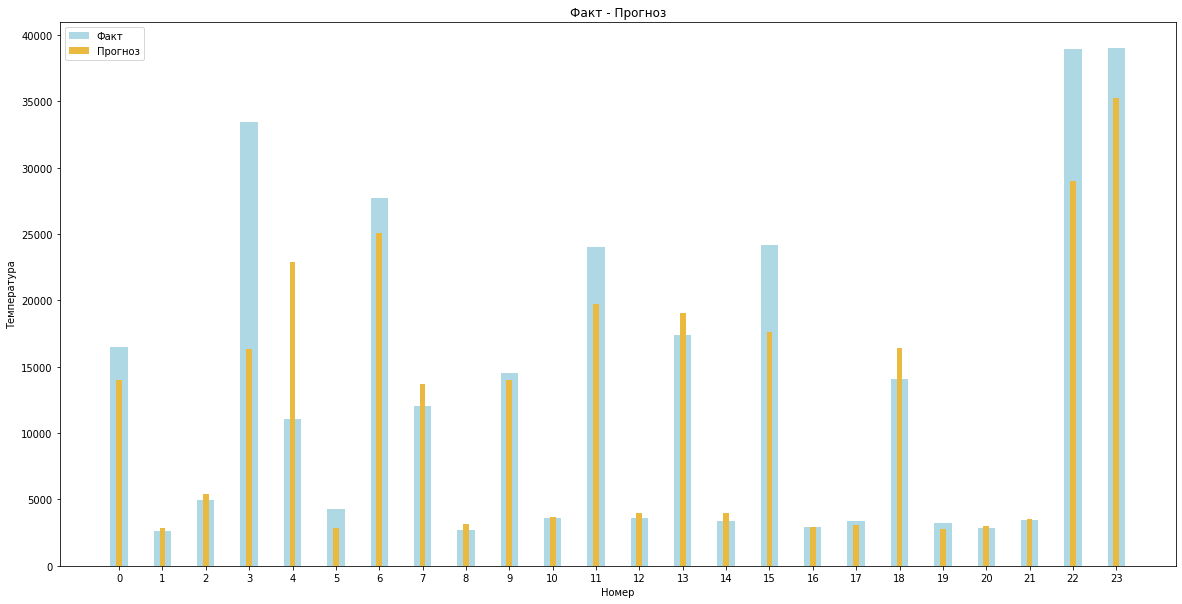

In [54]:
target = y_test
target = target.numpy()
target = pd.Series(target)

full_predictions = test_preds_b.detach().numpy()

preds =  pd.Series([x[0] for x in test_preds])

# Вызов функции для построения графика
graph2(target, preds)
plt.show()

`Вывод:` Наша базовая модель показала  результат - RMSE 3567, что достигло цели: < 4500 <br>

- При попытке улучшения модели, наилучшие результаты были достигнуты при применении batchNorm достигнув 3290 RMSE
- Результат не всегда был стабильным, вероятно, ввиду небольшой выборки.

## Выводы

`Общий вывод:` в результате проведённой работы были выявлены дубликаты в признаках которые были обработанны и устранены.

- также были найденны и удалены лишние призаки дублирующие значение индекса
- стоит отметить что что выборка крайне небольшая (240 наблюдений) что не могло не внести свои коррективы в процесс работы нейросети и повлиять на её предсказательную способность.
- в результате предобработки данных были удалены ненужные признаки, данные приведены в более структурированный и информативный вид
- ИАД выявил что скольно нибудь значимой кореляции с целевым признаком 'Temperature (K)' не прослеживается, за исключением звёзд красного цвета. Это говорит о том, что комбинаторика признаков носит более сложный характер. Простой таблицы корреляций, очевидно, не достаточно для выявления закономерностей, которые помогут нам предсказть температуру звезды. Это говорит о необходимости использования нейросети.
- в результате создания и применения базовой нейросети был достигнут показатель RMSE равный 3567 что достигло цели (<4500).
- впоследствии, была сделана попытка улучшения модели.
- для улучшения модели использовались следущие инструменты: Batch, Dropout и BatchNorm1d.
- лучше всего показала себя техника использования BatchNorm1d с помощью которой удалось достигнуть наименьшего показателя RMSE = 3290.